In [1]:
# Set up a cluster using dask
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()

cluster.scale(20)
cluster

In [2]:
#Make a client so you can see the progress of tasks (click the link that appears below)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.72ca27f5c10f46e0b70850d2bb6e7a75/status,


In [3]:
import intake
import pandas as pd
import pprint
import fsspec

import numpy as np
import xarray as xr
import xgcm
import s3fs

import matplotlib.pyplot as plt
%matplotlib inline

from fastjmd95 import jmd95numba

In [4]:
col = intake.open_esm_datastore(
    "https://raw.githubusercontent.com/NCAR/cesm-lens-aws/main/intake-catalogs/aws-cesm1-le.json")
col_subset = col.search(experiment="20C",variable=["TEMP", "SALT","PD","UVEL","VVEL","WVEL","SHF","VNT","WTT"])
#col_subset = col.search(experiment="20C",variable=["TEMP"])
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/tmp/ipykernel_369/1335283246.py:5: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


In [5]:
ds = dsets['ocn.20C.monthly']
theta = ds.TEMP
salt = ds.SALT
uvel = ds.UVEL
vvel = ds.VVEL
wvel = ds.WVEL
vnt = ds.VNT
wtt = ds.WTT
pot_dens = ds.PD

shf = ds.SHF

url = "s3://ncar-cesm-lens/ocn/static/grid.zarr"
fs = s3fs.S3FileSystem(anon=True)
grid_ds = xr.open_zarr(s3fs.S3Map(url, s3=fs))

In [6]:
th0 = theta.roll(nlon=60).sel(nlon=slice(0,130))
slt0 = salt.roll(nlon=60).sel(nlon=slice(0,130))
uvel0 = uvel.roll(nlon=60).sel(nlon=slice(0,130))
vel0 = vvel.roll(nlon=60).sel(nlon=slice(0,130))
wvel0 = wvel.roll(nlon=60).sel(nlon=slice(0,130))
pd0 = pot_dens.roll(nlon=60).sel(nlon=slice(0,130))
#vnt0 = vnt.roll(nlon=60)
#wtt0 = wtt.roll(nlon=60)
shf0 = shf.roll(nlon=60).sel(nlon=slice(0,130))
grid0 = grid_ds.roll(nlon=60,roll_coords=True).sel(nlon=slice(0,130))

#uvel0=uvel0.rename({'nlon':'vlon','nlat':'vlat'})
#vel0=vel0.rename({'nlon':'vlon','nlat':'vlat'})

In [7]:
#create grid object

#first merge v and w 
vel = vel0.to_dataset().merge(wvel0)
z_outer = np.concatenate((vel.z_w_top.values,np.asarray(500000).reshape((-1,))))
vel = vel.assign_coords(z_w_outer=z_outer)

from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

grid = Grid(vel, coords={'Z': {'center': 'z_t','outer': 'z_w_outer'}},periodic=False)

#calculate dz
dz = grid.diff(vel.z_w_outer,axis='Z',boundary='extend')

In [8]:
#Create a region mask for the Atlantic
atl_mask = grid0.REGION_MASK
atl_mask = atl_mask.where((atl_mask==6) | (atl_mask==8)| (atl_mask==-12))
atl_mask = atl_mask.where(np.isnan(atl_mask),1)

In [9]:
pd_jmd = jmd95numba.rho(slt0, th0, 0)
pd_jmd1 = jmd95numba.rho(slt0, th0, 1000)

rho_axis=np.concatenate((np.arange(20,27,0.1),np.arange(27,28.1,0.01)))
#rho_axis1=np.arange(25,33,0.1)

#transform into density coords
MOC = grid.transform(vel.VVEL*grid0.DXT*dz*atl_mask/100**3, target = rho_axis, target_data=(pd0*1000-1000), 
                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

#MOC_jmd = grid.transform(vel.VVEL*grid0.DXT*dz*atl_mask/100**3, target = rho_axis, target_data=(pd_jmd.rename('PD')-1000), 
#                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

#MOC_jmd1 = grid.transform(vel.VVEL*grid0.DXT*dz*atl_mask/100**3, target = rho_axis1, target_data=(pd_jmd1.rename('PD')-1000), 
#                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

thickness = grid.transform(xr.ones_like(vel.VVEL)*dz*atl_mask/100, target = rho_axis, target_data=(pd0*1000-1000), 
                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:303: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.<function raw_interp_function at 0x7fd615f9cb80>` instead of `Axis.<function raw_interp_function at 0x7fd615f9cb80>`
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/t

In [12]:
def stretch(rho):
    stretched = rho-22
    stretched[(rho>26.5) & (rho<27.8)] = (stretched[(rho>26.5) & (rho<27.8)]-4.5)*5+4.5
    stretched[(rho>=27.8)] = (stretched[(rho>=27.8)]-5.8)*10+11
    return stretched

In [13]:
#find the depths of some isopycnals
timeslice = slice('1940-01-01','2016-02-01')
thickness_mask = xr.ones_like(thickness).where(thickness>0)
tn_mean = (((thickness.cumsum('PD')*thickness_mask).sel(member_id=1,time=slice('2000-01-01','2016-01-01')).sum('time',skipna=False)).sum('nlon')
          )/((thickness_mask.sel(member_id=1,time=slice('2000-01-01','2016-01-01'))*atl_mask).sum('time',skipna=False).sum('nlon'))

MOC_mean = (MOC.sel(member_id=1,time=timeslice).mean('time').sum('nlon').cumsum('PD')/10**6)
MOC_mean.coords['depth']=(-tn_mean.ffill('PD').bfill('PD'))
MOC_mean.coords['latitude'] = grid0.TLAT.mean('nlon')

In [14]:
#MOC_loded = (MOC.sel(member_id=1,time=slice('1980-01-01','2016-01-01')).mean('time').sum('nlon').cumsum('PD')/10**6).load()

In [15]:
#MOC_ts = xr.open_dataset('/home/jovyan/amoc_heat_transport/MOC_ts.nc').MOC_ts.sel(member_id=slice(1,36))
MOC_42 = xr.open_dataset('/home/jovyan/amoc_heat_transport/MOC_42.nc').MOC_42.sel(member_id=slice(1,36))
MOC_34 = xr.open_dataset('/home/jovyan/amoc_heat_transport/MOC_34.nc').MOC_34.sel(member_id=slice(1,36))
MOC_26 = xr.open_dataset('/home/jovyan/amoc_heat_transport/MOC_26.nc').MOC_26.sel(member_id=slice(1,36))
MOC_5S = xr.open_dataset('/home/jovyan/amoc_heat_transport/MOC_5S.nc').MOC_5S.sel(member_id=slice(1,36))


MOC_42_smoothed = MOC_42.rolling(time=24).mean().dropna("time",how='all')
MOC_34_smoothed = MOC_34.rolling(time=24).mean().dropna("time",how='all')
MOC_26_smoothed = MOC_26.rolling(time=24).mean().dropna("time",how='all')
MOC_5S_smoothed = MOC_5S.rolling(time=24).mean().dropna("time",how='all')

In [16]:
#std_44 = detrended_MOC.std(dim='time')
std_42 = MOC_42_smoothed.std(dim='time')
std_34 = MOC_34_smoothed.std(dim='time')
std_26 = MOC_26_smoothed.std(dim='time')
std_5S = MOC_5S_smoothed.std(dim='time')
df_std = pd.DataFrame({'std_34':std_34.values/10**6,
                   'std_26':std_26.values/10**6,'std_5S':std_5S.values/10**6},index =np.arange(1,36),dtype='float')


In [17]:
#corr_44 = xr.corr(detrended_MOC,detrended_south,dim='time')
corr_26 = xr.corr(MOC_26_smoothed,MOC_42_smoothed,dim='time')
corr_5S = xr.corr(MOC_5S_smoothed,MOC_42_smoothed,dim='time')#.plot()
df_corr = pd.DataFrame({'corr_26':corr_26.values,'corr_5S':corr_5S.values},index =np.arange(1,36),dtype='float')

/tmp/ipykernel_369/2106694790.py:67: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1,wspace=0.1)
/tmp/ipykernel_369/2106694790.py:68: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig('figures_34/MOC_multilat.png')
/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


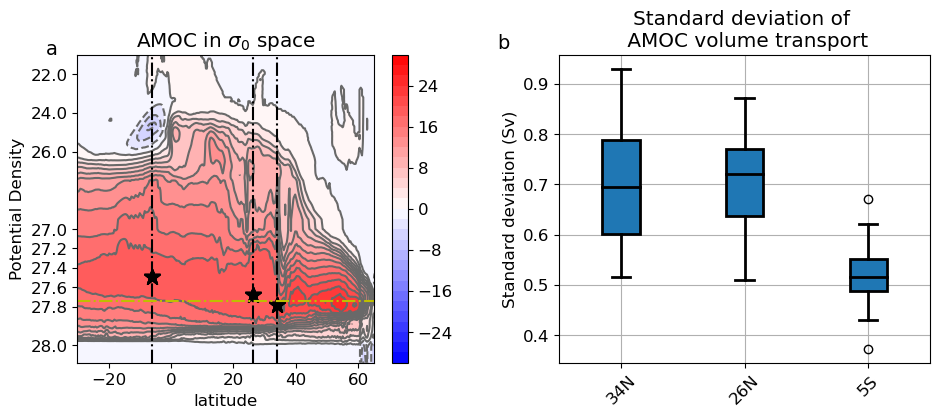

In [24]:
import matplotlib.gridspec as gridspec

plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(11,4),constrained_layout=True)
gs = gridspec.GridSpec(1, 2,hspace=0.9,wspace=0.3)

ax1 = fig.add_subplot(gs[0:2,0])

cs = plt.contourf(grid0.TLAT.mean('nlon').values,stretch(rho_axis[0:-1]),
             (MOC.sel(member_id=1,time=slice('1980-01-01','2016-01-01')).mean('time').sum('nlon').cumsum('PD')/10**6).squeeze().values.T, 
                  levels=np.arange(-30,31,2),cmap='bwr')
plt.contour(grid0.TLAT.mean('nlon').values,stretch(rho_axis[0:-1]),
             (MOC.sel(member_id=1,time=slice('1980-01-01','2016-01-01')).mean('time').sum('nlon').cumsum('PD')/10**6).squeeze().values.T, 
                  levels=np.arange(-30,31,2),colors='dimgrey')
plt.yticks(stretch(np.concatenate((np.arange(21,27,2),np.arange(27,28.4,0.2)))),labels=np.round(np.concatenate((np.arange(22,27,2),np.arange(27,28.4,0.2))),1))

plt.ylabel('Potential Density')
plt.xlabel('latitude')

plt.title('AMOC in $\sigma_0$ space')
plt.text(-40, stretch(np.array([20])), 'a',fontsize=14)

plt.colorbar(cs)


#hloc = stretch(np.asarray([27.715, 27.715]))
#plt.plot([40, 40],[hloc,hloc],marker='*',markersize=12,color='k')
#plt.axvline(40,color='k',lw=1.5,ls='-.')

hloc = stretch(np.asarray([27.785, 27.785]))
plt.plot([34, 34],[hloc,hloc],marker='*',markersize=12,color='k')
plt.axvline(34,color='k',lw=1.5,ls='-.')

hloc = stretch(np.asarray([27.68, 27.68]))
plt.plot([26.2, 26.2],[hloc,hloc],marker='*',markersize=12,color='k')
plt.axvline(26.2,color='k',lw=1.5,ls='-.')


hloc = stretch(np.asarray([27.49, 27.49]))
plt.plot([-6, -6],[hloc,hloc],marker='*',markersize=12,color='k')
plt.axvline(-6,color='k',lw=1.5,ls='-.')

hloc = stretch(np.asarray([27.74, 27.74]))
plt.axhline(hloc[0],color='y',lw=1.5,ls='-.')

plt.xlim(-30,65)
plt.gca().invert_yaxis()

ax2 = fig.add_subplot(gs[0:2,1])
boxprops = dict(linewidth=2.0, color='black')
whiskerprops = dict(linestyle='-',linewidth=2.0, color='black')
medianprops = dict(linestyle='-',linewidth=2.0, color='black')
capprops = dict(linestyle='-',linewidth=2.0, color='black')
ax5,row = df_std.boxplot(patch_artist=True,rot=45,figsize=(6, 8),return_type='both',
                     boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, capprops=capprops)
plt.ylabel('Standard deviation (Sv)')
plt.title('Standard deviation of \n AMOC volume transport')
plt.xticks([1, 2,3], ['34N','26N','5S'])
plt.text(0, 0.97, 'b',fontsize=14)



#plt.tight_layout()

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1,wspace=0.1)
fig.savefig('figures_34/MOC_multilat.png')

In [11]:
timeslice = slice('1940-01-01','2016-02-01')
MOC_42 = MOC.sel(nlat=298,time=timeslice).sum('nlon').cumsum('PD').max('PD')
MOC_42 = MOC_42.to_dataset(name='MOC_42').load()
MOC_42.to_netcdf('/home/jovyan/amoc_heat_transport/MOC_42.nc')

In [30]:
timeslice = slice('1940-01-01','2016-02-01')
MOC_34 = MOC.sel(nlat=286,time=timeslice).sum('nlon').cumsum('PD').max('PD')
MOC_34 = MOC_34.to_dataset(name='MOC_34').load()
MOC_34.to_netcdf('/home/jovyan/amoc_heat_transport/MOC_34.nc')

In [13]:
timeslice = slice('1940-01-01','2016-02-01')
MOC_26 = MOC.sel(nlat=270,time=timeslice).sum('nlon').cumsum('PD').max('PD')
MOC_26 = MOC_26.to_dataset(name='MOC_26').load()
MOC_26.to_netcdf('/home/jovyan/amoc_heat_transport/MOC_26.nc')

In [12]:
timeslice = slice('1940-01-01','2016-02-01')
MOC_5S = MOC.sel(nlat=163,time=timeslice).sum('nlon').cumsum('PD').max('PD')
MOC_5S = MOC_5S.to_dataset(name='MOC_5S').load()
MOC_5S.to_netcdf('/home/jovyan/amoc_heat_transport/MOC_5S.nc')

In [23]:
cluster.shutdown()

2023-04-28 14:59:04,053 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 1389, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLZeroReturnError: TLS/SSL connection has been closed (EOF) (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 206, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.10/s